In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import timeit

## First look at the data

In [2]:
train=pd.read_pickle("filtered_dataDB_complete.pkl")
objects = np.unique(train['object_id'])
target_types = np.hstack([np.unique(train['target']), [999]])
train

,object_id,mjd,passband,flux,flux_err,detected_bool,target
42,88338801,304.1140,4,180.269928,12.936621,1,994
43,88338801,304.9871,5,175.344162,29.581408,1,994
44,88338801,320.0114,3,186.399719,4.701161,1,994
46,88338801,331.9054,5,252.971573,19.144091,1,994
47,88338801,333.0579,4,233.591766,7.670842,1,994
...,...,...,...,...,...,...,...
517678,342844,442.7668,3,17.465534,2.443251,1,90
517679,342844,442.7670,4,24.341042,2.918342,1,90
517680,342844,442.7669,5,33.105377,5.942245,1,90
517684,342844,451.8677,4,16.954691,3.976537,1,90


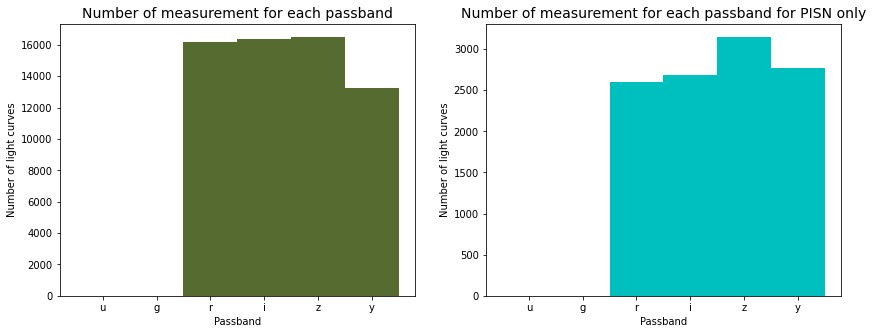

In [3]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.title('Number of measurement for each passband',fontsize=14)
plt.hist(train['passband'],bins=[0,1,2,3,4,5,6],color='darkolivegreen')
plt.ylabel('Number of light curves')
plt.xlabel('Passband')
plt.xticks(np.arange(6)+0.5, ['u','g','r','i','z','y']);

plt.subplot(1,2,2)
plt.title('Number of measurement for each passband for PISN only',fontsize=14)
plt.hist(train.loc[train['target']==994,'passband'],bins=[0,1,2,3,4,5,6],color='c')
plt.ylabel('Number of light curves')
plt.xlabel('Passband')
plt.xticks(np.arange(6)+0.5, ['u','g','r','i','z','y']);

## Define useful functions

In [4]:
#Dictionnaire de correspondance des passband et des targets
passband_list = {0:'u',1:'g',2:'r',3:'i',4:'z',5:'y'}
target_dict={90:'SNIa',67:'SNIa-91bg',
             52:'SNIax',42:'SNII',
             62:'SNIbc',95:'SLSN-I',
             15:'TDE',64:'KN',
             88:'AGN',92:'RRL',
             65:'M-dwarf',16:'EB',
             53:'Mira',6:'Lens-Single',
             994:'PISN', 999:'UNKNOWN'}


In [20]:
def compare(ide,band,table,model,nb_param,band_used):
    
    obj = train.loc[(train['object_id']==ide) & (train['passband']==band)]
    flux=np.array(obj['flux'])
    time=np.array(obj['mjd'])
    fluxerr=np.array(obj['flux_err'])
    obj_target= np.array(train[train['object_id']==ide]['target'])[0]
    
    if len(time)<=1:
        print('Not enough points for object',ide,'in band',band)
        
    else :
        # Let's fit the data as a scatter
        plt.errorbar(time,flux,yerr=fluxerr,label="data band %s"%(band),fmt='o')
        plt.title('Object n°%s : %s'%(ide,target_dict.get(obj_target)))
        plt.xlabel('Time')
        plt.ylabel('Flux')


        #And the prediction
        x=np.linspace(time.min(),time.max(),200)
        first_para_band=nb_param*(band-band_used.min())
        last_para_band=nb_param*((band-band_used.min())+1)-1
        
        obj_para=np.array(table[table['object_id']==ide].loc[:,first_para_band:last_para_band])[0]
        plt.plot(x,model(x,*obj_para),label='fit band %s'%(band),color='red')
        plt.legend()
        
def get_target(ide):
    return train.loc[train['object_id']==ide,'target'].min()

## Create the fitting models

In [7]:
# We define the Bazin model
def bazin(time, a, b, t0, tfall, trise):
    X = np.exp(-(time - t0) / tfall) / (1 + np.exp((time - t0) / trise))
    return a * X + b

def errfunc_bazin(params,time, flux):
    return abs(flux - bazin(time,*params))

In [8]:
def poly(time,a,b,c):
    return c+b*time+a*time**2

def errfunc_poly(params,time, flux):
    return abs(flux - poly(time,*params))

## Import a parameter table and plot it

In [15]:
param_table=pd.read_pickle("Models/polyDB_complete.pkl")
pltmodel=poly
band_used=np.array([2,3,4,5])
nb_param=3

"""
param_table=pd.read_pickle("Models/bazinDB_complete.pkl")
pltmodel=bazin
band_used=np.array([2,3,4,5])
nb_param=5
"""

'\nparam_table=pd.read_pickle("Models/bazinDB_complete.pkl")\npltmodel=bazin\nband_used=np.array([2,3,4,5])\nnb_param=5\n'

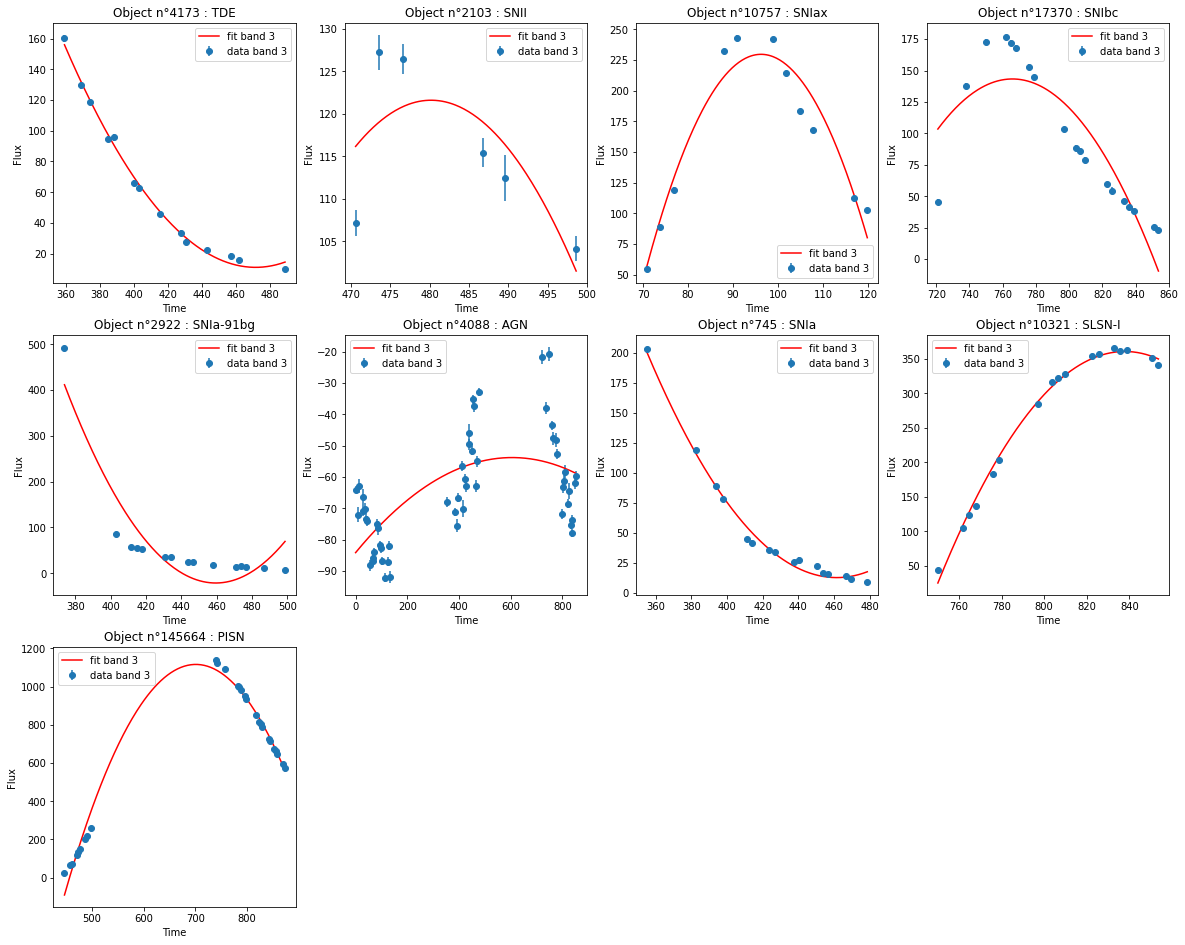

In [21]:
# Now let's use this function to see how well each object is fited

plt.figure(figsize=(20,22))
a=0

for i in target_types[0:len(target_types)-1]:
    a+=1
    j=0
    obj=objects[j]
    obj_target= get_target(obj)

    while (obj_target!=i) and (j!=len(objects)-1) :
        j+=1
        obj=objects[j]
        obj_target= np.array(train[train['object_id']==obj]['target'])[0]
  
    plt.subplot(4,4,a)
    compare(obj,3,param_table,pltmodel,nb_param,band_used)
    

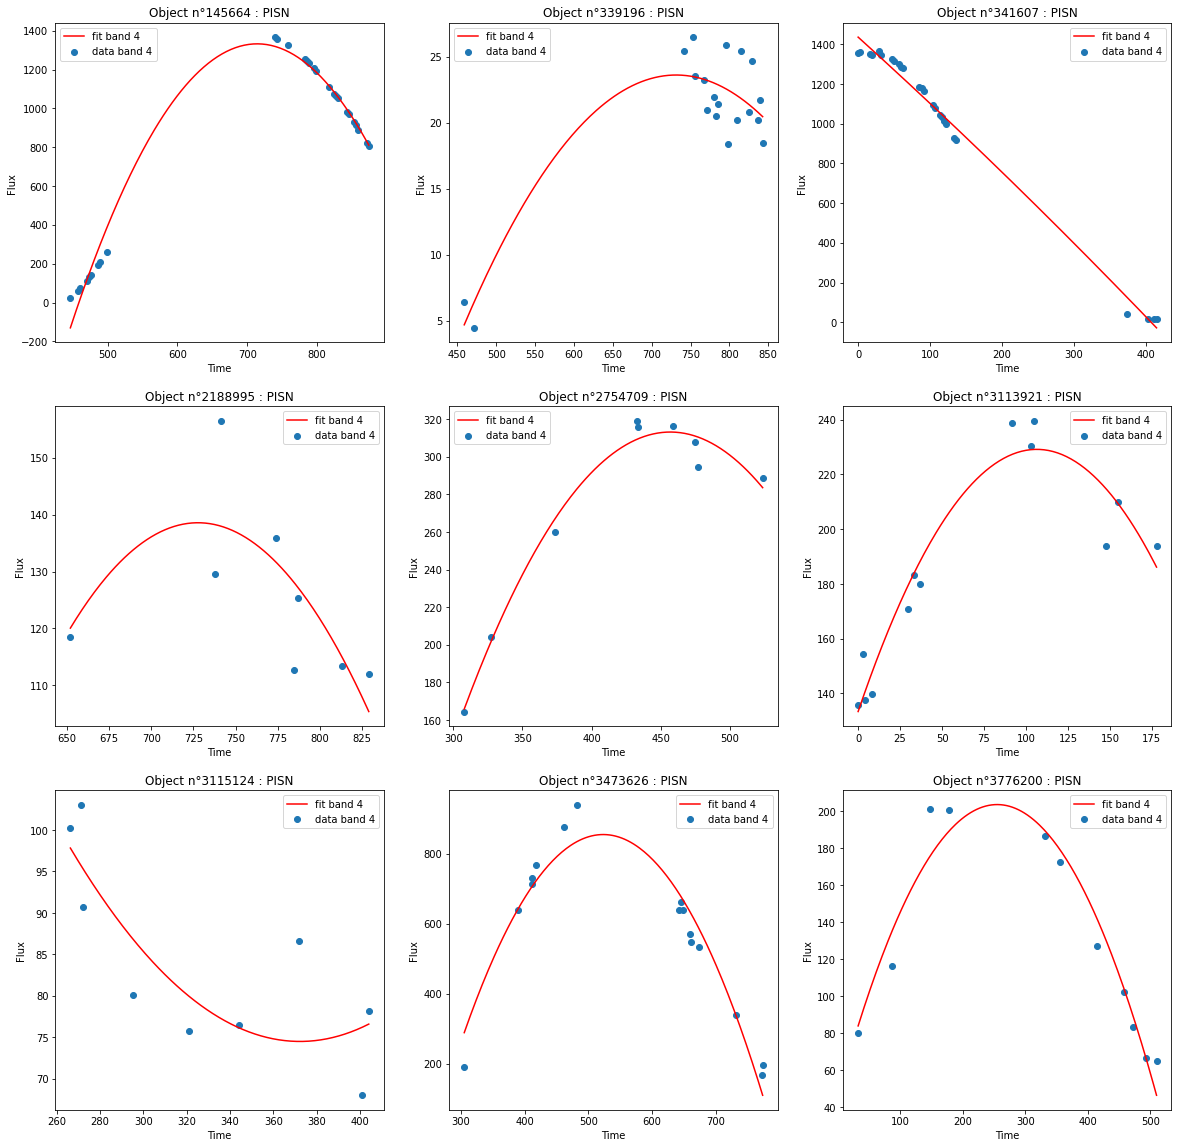

In [17]:
# Now let's use this function to see how well PISN are fitted
       
plt.figure(figsize=(20,20))
ids_type = np.unique(train.loc[train['target']==994,'object_id'])

for i in range(9):

    obj=ids_type[i]
    obj_target= np.array(train[train['object_id']==obj]['target'])[0]
    plt.subplot(3,3,i+1)
    compare(obj,4,param_table,pltmodel,nb_param,band_used)

Not enough points for object 80772503 in band 0
Not enough points for object 80772503 in band 1


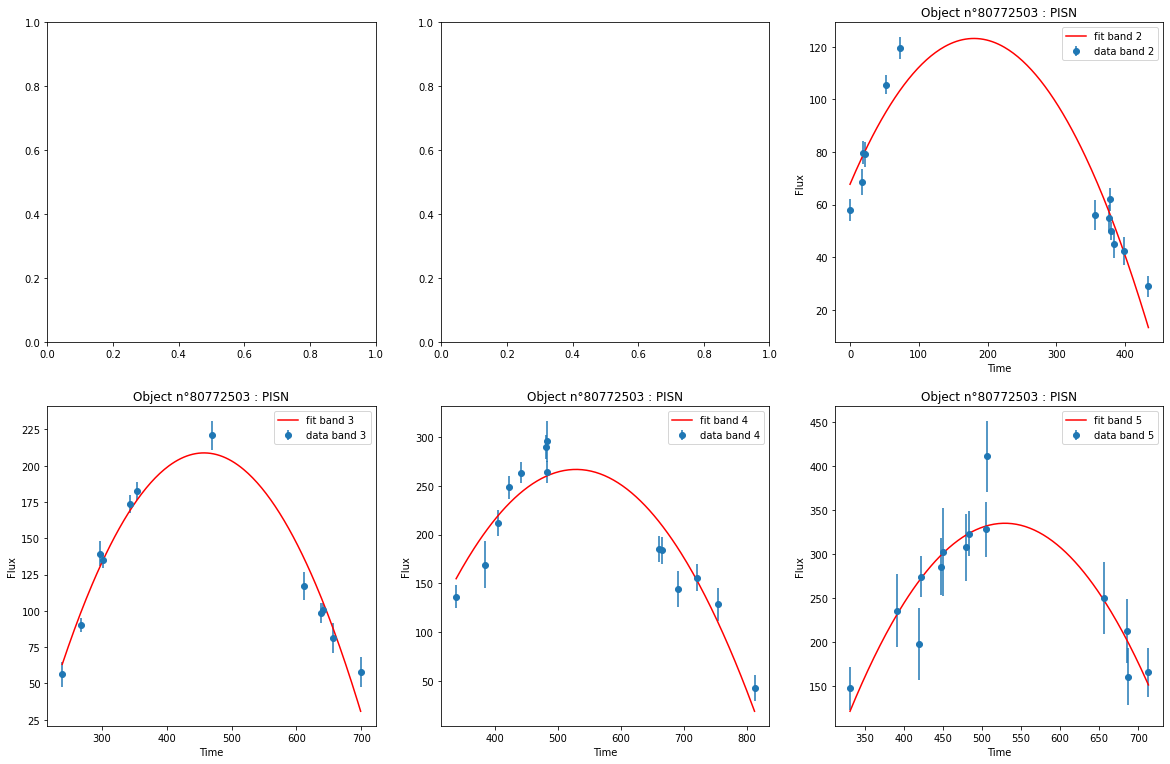

In [26]:
#For a specific PISN 

plt.figure(figsize=(20,20))
ids_type = np.unique(train.loc[train['target']==994,'object_id'])
obj=np.random.choice(ids_type)

for i in (0,1,2,3,4,5):

    obj_target= np.array(train[train['object_id']==obj]['target'])[0]
    plt.subplot(3,3,i+1)
    
    compare(obj,i,param_table,pltmodel,nb_param,band_used)